

## 🩺 COVID-19 Detection from CT Scan Images using TensorFlow

### 📌 Project Overview

This project focuses on detecting **COVID-19 from chest CT scan images** using deep learning techniques. A convolutional neural network (CNN) model is developed and trained using **TensorFlow** to classify CT images and assist in automated medical image analysis.

The project is based on the **COVIDx CT dataset** available on Kaggle and aims to demonstrate how deep learning can support medical diagnosis by analyzing CT scan data.

### 📂 Dataset

* **Dataset Source:** COVIDx CT Dataset (Kaggle)  https://www.kaggle.com/datasets/hgunraj/covidxct
* **Data Type:** Chest CT scan images
* **Classes:** COVID-19 positive and non-COVID cases
* The dataset contains labeled CT images collected from real clinical cases.

### 🧠 Model & Approach

* Built using **TensorFlow** and **Keras**
* A **Convolutional Neural Network (CNN)** architecture is used for image classification
* Image preprocessing steps include resizing, normalization, and data augmentation
* The model is trained to learn discriminative features from CT images to identify COVID-19 infections


In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


In [13]:
DATA_DIR = "data"
IMAGE_DIR = os.path.join(DATA_DIR, "3A_images")

TRAIN_TXT = os.path.join(DATA_DIR, "train_COVIDx_CT-3A.txt")
VAL_TXT   = os.path.join(DATA_DIR, "val_COVIDx_CT-3A.txt")
TEST_TXT  = os.path.join(DATA_DIR, "test_COVIDx_CT-3A.txt")


In [20]:
def load_txt_to_df(txt_path):
    filenames = []
    labels = []

    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 6:
                continue

            fname, cls, _, _, _, _ = parts[:]
            cls = int(cls)

            label = 1 if cls == 2 else 0

            filenames.append(fname)
            labels.append(label)

    df = pd.DataFrame({
        "filename": filenames,
        "label": labels
    })

    df["path"] = df["filename"].apply(lambda x: os.path.join(IMAGE_DIR, x))
    return df

In [21]:
train_df = load_txt_to_df(TRAIN_TXT)
val_df   = load_txt_to_df(VAL_TXT)
test_df  = load_txt_to_df(TEST_TXT)

In [27]:
all_df.shape

(425024, 3)

In [28]:
from sklearn.utils import shuffle

all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
all_df = shuffle(all_df, random_state=1988).reset_index(drop=True)


In [29]:
all_df.shape

(425024, 3)

### For running the model on the system here, I have limited the number of samples in the train/test split. By using a GPU, the full dataset can be used.

In [30]:
train_df = all_df.iloc[:8000].reset_index(drop=True)
val_df   = all_df.iloc[8000:9000].reset_index(drop=True)
test_df  = all_df.iloc[9000:10000].reset_index(drop=True)

In [31]:
len(train_df), len(val_df), len(test_df)


(8000, 1000, 1000)

In [34]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [36]:
def make_dataset(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["path"].values, df["label"].values)
    )
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


In [37]:
train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df)


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, 3, activation="relu", padding="same", input_shape=(224,224,3)),
    MaxPool2D(2),

    Conv2D(64, 3, activation="relu", padding="same"),
    MaxPool2D(2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

early_stop = EarlyStopping(monitor="val_loss",patience=3)

/Users/mohammadshafiei/Desktop/covidx-CT/.env/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [40]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, callbacks=[early_stop]
)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 326ms/step - accuracy: 0.8422 - loss: 0.4188 - val_accuracy: 0.8940 - val_loss: 0.2756
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 321ms/step - accuracy: 0.9060 - loss: 0.2288 - val_accuracy: 0.9090 - val_loss: 0.2186
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 318ms/step - accuracy: 0.9494 - loss: 0.1355 - val_accuracy: 0.9230 - val_loss: 0.2189
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 319ms/step - accuracy: 0.9635 - loss: 0.0939 - val_accuracy: 0.9350 - val_loss: 0.1836
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 321ms/step - accuracy: 0.9799 - loss: 0.0563 - val_accuracy: 0.9370 - val_loss: 0.2097
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 326ms/step - accuracy: 0.9806 - loss: 0.0554 - val_accuracy: 0.9290 - val_loss: 0.2152
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 330ms/step - accuracy: 0.9852 - loss: 0.0395 - val_accuracy: 0.9410 - val_loss: 0.1813
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 321ms/step - accuracy: 0.9926 - loss: 0

In [41]:
losses = pd.DataFrame(model.history.history)

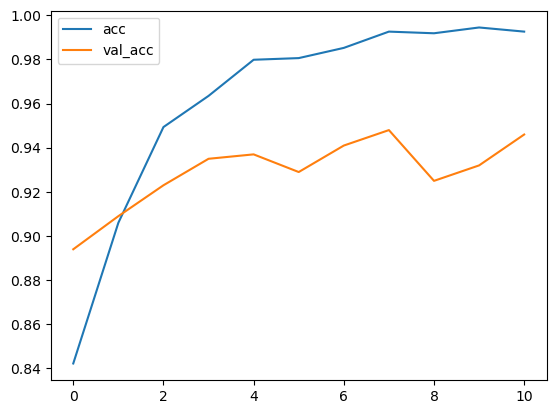

In [42]:
plt.plot(losses["accuracy"], label="acc")
plt.plot(losses["val_accuracy"], label="val_acc")
plt.legend();

In [46]:
from sklearn.metrics import confusion_matrix, classification_report


np.int64(1)

In [56]:
y_pred = model.predict(val_df[:])


ValueError: Invalid dtype: object